<span style="display:inline-block;position:relative;font-size:48px;background-color: #d9edab;padding:200px 10px;width:100%;text-align:center">TARGET CUSTOMER</span><br><strong style="display:block;font-size:30px;padding-top:20px">PSO</strong>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time as time

!pip3 install scikit-learn-intelex

from sklearnex import patch_sklearn
patch_sklearn()

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 6.5 MB/s 
     |████████████████████████████████| 26.0 MB 83.5 MB/s 
     |████████████████████████████████| 300.3 MB 15 kB/s 
     |████████████████████████████████| 4.0 MB 45.0 MB/s 


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/hsuecu/data_set/main/targetCustomer.csv")
data.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no


In [3]:
if __name__=="__main__":
    for i in data.columns:
        data[i].replace('unknown', np.NAN, inplace=True)

In [4]:
data.drop(['poutcome','day','month'], axis=1, inplace=True)
data['contact'].fillna('cellular', inplace=True)
data = data.drop_duplicates(subset=['ID'], keep='first')

In [5]:
if __name__=="__main__":
    count = 0
    for i in range(data.shape[0]):
        for j in data.iloc[i].isna():
            if j:
                count += 1
                break
    print(f'Useless row entries are:{round(count/data.shape[0] * 100, 3)}%')

Useless row entries are:33.149%


# Data Processing

In [6]:
data.dropna(axis=0, inplace=True)

In [7]:
temp={
    'entrepreneur':10,
    'management':9,
    'admin.':8,
    'services':7,
    'technician':6,
    'retired':5,
    'blue-collar':4,
    'self-employed':3,
    'student':2,
    'housemaid':1,
    'unemployed':0
}
data['job']=data['job'].map(temp)
data['subscribed']=data['subscribed'].apply(lambda i: 1 if i=='yes' else 0)

to_oneHotEncode=['marital', 'education',
                 'default', 'housing',
                 'loan', 'contact']
data_intermediate=pd.get_dummies(data=data[to_oneHotEncode],
                                drop_first=False)
data_intermediate.info(verbose=False)

data = pd.concat([data, data_intermediate], axis = 1)
data.drop(to_oneHotEncode, axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30224 entries, 2 to 31646
Columns: 14 entries, marital_divorced to contact_telephone
dtypes: uint8(14)
memory usage: 649.3 KB


In [8]:
X=data.drop(['subscribed', 'ID'], axis=1)
y=data['subscribed']

from imblearn.under_sampling import RandomUnderSampler
cc=RandomUnderSampler(sampling_strategy=1)
X, y=cc.fit_resample(X, y)
y.value_counts()

0    3527
1    3527
Name: subscribed, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
X_train,  X_test,y_train, y_test = train_test_split(X,y, train_size = 0.7 )

In [10]:
print(f'X_train:{X_train.shape}\n\
X_test:{X_test.shape}\n\
y_train:{y_train.shape}\n\
y_test:{y_test.shape}')

X_train:(4937, 21)
X_test:(2117, 21)
y_train:(4937,)
y_test:(2117,)


In [11]:
# function to evaluate
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, average_precision_score
from sklearn.model_selection import StratifiedKFold
def analyse(model, xtrain, ytrain, xtest, ytest):
    model.fit(xtrain, ytrain)
    sk = StratifiedKFold(3, shuffle=True, random_state=0)
    sf_scorer = cross_validate(model, xtrain, ytrain, 
                 scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'],
                 cv=sk)
    accuracy = sf_scorer['test_accuracy'].mean()
    recall = sf_scorer['test_recall'].mean()
    precision = sf_scorer['test_precision'].mean()
    roc_auc = sf_scorer['test_roc_auc'].mean()
    f1score = sf_scorer['test_f1'].mean()
    try:
        y_score_test = model.decision_function(xtest)
        y_score_train = model.decision_function(xtrain)
    except:
        y_score_test = model.predict_proba(xtest)[:,1]
        y_score_train = model.predict_proba(xtrain)[:,1]
    ypred = model.predict(xtest)
    ret = {'train':{'pr auc': average_precision_score(ytrain, y_score_train),
                'accuracy': accuracy,
                'recall':recall,
                'precision':precision,
                'roc auc':roc_auc,
                'f1 score': f1score},
           'test':{'pr auc': average_precision_score(ytest, y_score_test),
                'accuracy':accuracy_score(ytest, ypred),
                'recall':recall_score(ytest, ypred),
                'precision':precision_score(ytest, ypred),
                'roc auc':roc_auc_score(ytest, y_score_test),
                'f1 score': f1_score(ytest, ypred)}}
    return ret

In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, auc, precision_recall_curve

def analyseANN(ANNmodel, model, xtrain, ytrain, xtest, ytest):
    
    ypred =  model.predict(xtrain)
    ypred_test = model.predict(xtest)
    precision_train, recall_train, thresholds = precision_recall_curve(ytrain, ypred)
    precision_test, recall_test, thresholds = precision_recall_curve(y_test, ypred_test)

    for i in range(len(ypred)):
        if ypred[i] <=0.5:
            ypred[i] =0
        else: 
            ypred[i] =1
    for i in range(len(ypred_test)):
        if ypred_test[i] <=0.5:
            ypred_test[i] =0
        else: 
            ypred_test[i] =1
    
    #ypred = y_pred_prob.where(y_pred_prob<0.5,0,1 ) 
    accuracy = accuracy_score(ytrain, ypred)
    recall = recall_score(ytrain, ypred)
    precision = precision_score(ytrain, ypred)
    roc_auc = roc_auc_score(ytrain, ypred)
    f1score = f1_score(ytrain, ypred)

    ret = {'train':{'pr auc': auc(recall_train, precision_train),
                    'accuracy': accuracy,
                    'recall':recall,
                    'precision':precision,
                    'roc auc':roc_auc,
                    'f1 score': f1score},
               'test':{'pr auc': auc(recall_test, precision_test),
                    'accuracy':accuracy_score(ytest, ypred_test),
                    'recall':recall_score(ytest, ypred_test),
                    'precision':precision_score(ytest, ypred_test),
                    'roc auc':roc_auc_score(ytest, ypred_test),
                    'f1 score': f1_score(ytest, ypred_test)}}
    
    history_df = pd.DataFrame(ANNmodel.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
    plt.ylim(0.5, 1)
    return ret

# BASE CASE

In [ ]:
##                     ##
## LOGISTIC REGRESSION ##
##                     ##

from sklearn.linear_model import LogisticRegression
import json
lr = LogisticRegression(random_state=42)

print(json.dumps(analyse(lr, X, y, X_test, y_test), indent=2))

{
  "train": {
    "pr auc": 0.8330153203840991,
    "accuracy": 0.7689236548156764,
    "recall": 0.7519103102233801,
    "precision": 0.7784284295349776,
    "roc auc": 0.8395811392777307,
    "f1 score": 0.7648633929296653
  },
  "test": {
    "pr auc": 0.8199436433760874,
    "accuracy": 0.7600377893245158,
    "recall": 0.7424812030075187,
    "precision": 0.771484375,
    "roc auc": 0.8401604081428643,
    "f1 score": 0.7567049808429118
  }
}


In [ ]:
##                     ##
## XG BOOST CLASSIFIER ##
##                     ##

from xgboost.sklearn import XGBClassifier
params = {
            'booster':'gbtree',
            'objective':'binary:logistic',
            'max_depth': 3,
            'learning_rate': 1,
            'n_estimators':100,
            "eval_metric": ['logloss'],
            'random_state': 42
        }         
           
          
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)
print(json.dumps(analyse(xgb_clf, X, y, X_test, y_test), indent=2))

{
  "train": {
    "pr auc": 0.956185940805006,
    "accuracy": 0.7907566471931181,
    "recall": 0.7984100448690116,
    "precision": 0.786399512041234,
    "roc auc": 0.8685636814792496,
    "f1 score": 0.7923454416817816
  },
  "test": {
    "pr auc": 0.956867242006693,
    "accuracy": 0.896551724137931,
    "recall": 0.8994360902255639,
    "precision": 0.8952291861552854,
    "roc auc": 0.9575496790409072,
    "f1 score": 0.8973277074542897
  }
}


In [ ]:
##                          ##
## RANDOM FOREST CLASSIFIER ##
##                          ##


from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(max_depth = 3)

print(json.dumps(analyse(rforest, X, y, X_test, y_test), indent=2))

{
  "train": {
    "pr auc": 0.8519950786817129,
    "accuracy": 0.7974205987513394,
    "recall": 0.8378238529454335,
    "precision": 0.7751934400322154,
    "roc auc": 0.8632363251423018,
    "f1 score": 0.8052775162207944
  },
  "test": {
    "pr auc": 0.8365181400353241,
    "accuracy": 0.7931034482758621,
    "recall": 0.8336466165413534,
    "precision": 0.7726480836236934,
    "roc auc": 0.8621522645645453,
    "f1 score": 0.8019891500904159
  }
}


In [ ]:
##                        ##
## NAIVE BAYES CLASSIFIER ##
##                        ##


from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

print(json.dumps(analyse(gnb, X_train, y_train, X_test, y_test), indent=2))

{
  "train": {
    "pr auc": 0.7908917154567041,
    "accuracy": 0.7462019620805589,
    "recall": 0.8067397482744619,
    "precision": 0.7196048019992487,
    "roc auc": 0.8061517346997403,
    "f1 score": 0.7603314467916994
  },
  "test": {
    "pr auc": 0.7553690195099754,
    "accuracy": 0.7288615965989608,
    "recall": 0.8167293233082706,
    "precision": 0.6963141025641025,
    "roc auc": 0.7818723268284672,
    "f1 score": 0.7517301038062284
  }
}


In [ ]:
##                ##
## SVC CLASSIFIER ##
##                ##


from sklearn.svm import SVC
svc = SVC(C=1, kernel='rbf', gamma='scale')

print(json.dumps(analyse(svc, X_train, y_train, X_test, y_test), indent=2))

{
  "train": {
    "pr auc": 0.816503666060145,
    "accuracy": 0.7301981654583708,
    "recall": 0.6727568006496142,
    "precision": 0.7592280865247526,
    "roc auc": 0.8204196799302225,
    "f1 score": 0.7133476507321195
  },
  "test": {
    "pr auc": 0.7986630886484801,
    "accuracy": 0.7189418989135569,
    "recall": 0.6550751879699248,
    "precision": 0.7535135135135135,
    "roc auc": 0.8082849574077644,
    "f1 score": 0.7008547008547008
  }
}


In [ ]:
##                ##
## ANN CLASSIFIER ##
##                ##


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

def create_ann(dense_layers, dense_nodes, learning_rate, dropout_rate):
    ann = Sequential()
    ann.add(Dense(units = dense_nodes, activation='relu', input_shape=[(X_train.shape[1])]))
    ann.add(Dropout(dropout_rate))
    ann.add(BatchNormalization())

    for i in range(dense_layers):
        ann.add(Dense(units = dense_nodes, activation='relu'))
        ann.add(Dropout(dropout_rate))
        ann.add(BatchNormalization())
    
    ann.add(Dense(units = 1, activation='sigmoid')) 
    ann.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['binary_accuracy'])
    return ann

def Model(dense_layers, dense_nodes, learning_rate, dropout_rate, batch_size):
    ann = create_ann(dense_layers, dense_nodes, learning_rate, dropout_rate)
    es = EarlyStopping(min_delta=0.01, patience=10)
    classifier = ann.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size,
                                     epochs=100, verbose=0,callbacks = es)
    return classifier, ann

running for: 0m, 19s
{
  "train": {
    "pr auc": 0.8411894523922213,
    "accuracy": 0.7796232529876443,
    "recall": 0.7775071051563135,
    "precision": 0.780040733197556,
    "roc auc": 0.7796185485361196,
    "f1 score": 0.7787718584790565
  },
  "test": {
    "pr auc": 0.8253344957238198,
    "accuracy": 0.7515351913084554,
    "recall": 0.7274436090225563,
    "precision": 0.7663366336633664,
    "roc auc": 0.7516610257838328,
    "f1 score": 0.746383799421408
  }
}


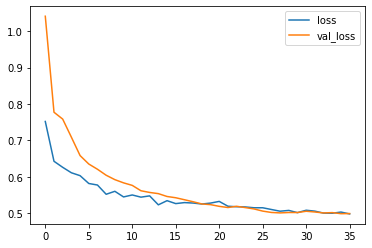

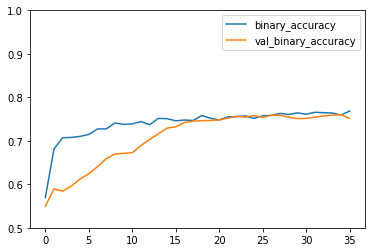

In [ ]:
_start = time.time()

ANNmodel , model= Model(dense_layers =2 , dense_nodes = 128, learning_rate = 0.001, dropout_rate = 0.3, batch_size = 1000)

ret = analyseANN(ANNmodel, model, X_train, y_train, X_test, y_test)

_end = time.time()

print(f'running for: {int((_end-_start)/60)}m, {int((_end-_start)%60)}s')
print(json.dumps(ret, indent=2))

# PSO OPTIMIZED

In [13]:
!pip install optunity

import optunity
import optunity.metrics
from bisect import bisect
from sklearn.model_selection import cross_val_score
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 30.4 MB/s 
  Created wheel for optunity: filename=Optunity-1.1.1-py3-none-any.whl size=72032 sha256=3a2faf76dbe526c44f4469d75c36202e49f25aa1ef723e3a7b5602dcd9e7c735
  Stored in directory: /root/.cache/pip/wheels/0d/0e/31/a4763ff822a20f88a61dd3bb1c8b78a8f25c605392fe956d07
Successfully built optunity


In [ ]:
##                     ##
## LOGISTIC REGRESSION ##
##                     ##

from sklearn.linear_model import LogisticRegression
import json

search = {
    'penalty':[0, 1], # none l1 l2 elasticnet
    'C': [1e-6, 1e-2], # inverse of regularization strength
    'l1_ratio':[0, 1],
    'max_iter':[10, 1000]
}

data = X.values.tolist()
labels = y.values.tolist()
counter=0

@optunity.cross_validated(x=data, y=labels, num_folds=3)

def performance_lr(x_train, y_train, x_test, y_test,
                  penalty=None, max_iter=None, C=None,
                   l1_ratio=None):
    global counter
    def mapper(f, breakpoint=[], cat=[]):
        return cat[bisect(breakpoint, f)]
    
    penalty=mapper(penalty, breakpoint=[0.25, 0.5, 0.75],
                   cat=['none', 'l1', 'l2', 'elasticnet'])
    max_iter = int(max_iter)
    
    model = LogisticRegression(penalty=penalty, l1_ratio=l1_ratio, C=C,
                               max_iter=max_iter, solver='saga')
    # mark this issue.
    # only saga allows using any penalty hence for 
    # ease of implementation we use saga.
    l = cross_val_score(model, data, labels, cv=3,
                                    scoring='roc_auc', error_score='raise')
    scores = np.mean(l)
    counter+=1
    print(counter, end=' ')
    return scores

In [ ]:
_start = time.time()

optimal_confg, info, _ = optunity.maximize(performance_lr,
                                           solver_name='particle swarm',
                                           num_evals=100,
                                           **search)

_end = time.time()

# only in seconds

print(f'running for: {int((_end-_start)/60)}m, {int((_end-_start)%60)}s')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [ ]:
def mapper(f, breakpoint=[], cat=[]):
        return cat[bisect(breakpoint, f)]

optimal_config_format = optimal_confg.copy()
optimal_config_format['penalty'] = mapper(optimal_config_format['penalty'],
                                          breakpoint=[0.25, 0.5, 0.75],
                                          cat=['none', 'l1', 'l2', 'elasticnet'])
optimal_config_format['max_iter'] = int(optimal_config_format['max_iter'])
print(json.dumps(optimal_config_format, indent=2))
print(f'best cv_score:{info.optimum}')

{
  "penalty": "none",
  "C": 0.00431287345703125,
  "l1_ratio": 0.43861328125000004,
  "max_iter": 909
}
best cv_score:0.7974536405924683


In [ ]:
final_lr = LogisticRegression(solver='saga', **optimal_config_format)
print(json.dumps(analyse(final_lr, X_train, y_train, X_test, y_test), indent=2))

{
  "train": {
    "pr auc": 0.8013413642680013,
    "accuracy": 0.6467442487452311,
    "recall": 0.9378806333739341,
    "precision": 0.5940033242874837,
    "roc auc": 0.8045720505792286,
    "f1 score": 0.7263269527505773
  },
  "test": {
    "pr auc": 0.7842935140773933,
    "accuracy": 0.6608408124704771,
    "recall": 0.9238721804511278,
    "precision": 0.6067901234567902,
    "roc auc": 0.7859891894979615,
    "f1 score": 0.7324888226527572
  }
}


In [ ]:
##                          ##
## RANDOM FOREST CLASSIFIER ##
##                          ##

search = {
    'n_estimators': [10, 100],
    'criterion':[0, 1],
    'max_depth':[3, 10],
    'max_leaf_nodes':[1, 100],
    'max_features':[0, 1],
    'min_weight_fraction_leaf':[0, 0.5]
}

data = X.values.tolist()
labels = y.values.tolist()

counter=0

@optunity.cross_validated(x=data, y=labels, num_folds=3)

def performance_rf(x_train, y_train, x_test, y_test,
                  n_estimators=None,
                  criterion=None,
                  max_depth=None,
                  max_leaf_nodes=None,
                  max_features=None,
                  min_weight_fraction_leaf=None):
    global counter
    def mapper(f, breakpoint=[], cat=[]):
        return cat[bisect(breakpoint, f)]
    
    criterion=mapper(criterion, breakpoint=[0.5],
                    cat=['gini', 'entropy'])
    max_features=mapper(max_features, breakpoint=[0.33, 0.66],
                       cat=['sqrt', 'log2', None])
    
    model=RandomForestClassifier(n_estimators=int(n_estimators),
                                criterion=criterion,
                                max_depth=max_depth,
                                max_leaf_nodes=int(max_leaf_nodes),
                                max_features=max_features,
                                min_weight_fraction_leaf=min_weight_fraction_leaf,
                                n_jobs=-1,
                                random_state=42)
    scores=np.mean(cross_val_score(model, data, labels, cv=3, n_jobs=-1,
                                    scoring='roc_auc', error_score='raise'))
    counter+=1
    print(counter, end=' ')
    return scores

In [ ]:
_start = time.time()

optimal_confg, info, _ = optunity.maximize(performance_rf,
                                           solver_name='particle swarm',
                                           num_evals=100,
                                           **search)

_end = time.time()

print(f'running for: {int((_end-_start)/60)}m, {int((_end-_start)%60)}s')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 running for: 4m, 58s


In [ ]:
def mapper(f, breakpoint=[], cat=[]):
        return cat[bisect(breakpoint, f)]

optimal_config_format = optimal_confg.copy()
optimal_config_format['criterion'] = mapper(optimal_config_format['criterion'],
                                          breakpoint=[0.5],
                                          cat=['gini', 'entropy'])

optimal_config_format['max_features'] = mapper(optimal_config_format['max_features'],
                                         breakpoint=[0.33, 0.66],
                                         cat=['sqrt', 'log2', None])

optimal_config_format['n_estimators'] = int(optimal_config_format['n_estimators'])
optimal_config_format['max_leaf_nodes'] = int(optimal_config_format['max_leaf_nodes'])
print(json.dumps(optimal_config_format, indent=2))
print(f'best cv_score:{info.optimum}')

{
  "n_estimators": 94,
  "criterion": "entropy",
  "max_depth": 8.200864067594278,
  "max_leaf_nodes": 86,
  "max_features": "log2",
  "min_weight_fraction_leaf": 0.005341400814140248
}
best cv_score:0.883261356268517


In [ ]:
final_rf = RandomForestClassifier(n_jobs=-1,
                                  random_state=42,
                                  **optimal_config_format)
print(json.dumps(analyse(final_rf,
                         X_train,
                         y_train,
                         X_test,
                         y_test),
                 indent=2))

{
  "train": {
    "pr auc": 0.902407112301605,
    "accuracy": 0.810209515930671,
    "recall": 0.8380024360535931,
    "precision": 0.7932886548989041,
    "roc auc": 0.8868300258357374,
    "f1 score": 0.8149246007474172
  },
  "test": {
    "pr auc": 0.8502666572566465,
    "accuracy": 0.7992442135096836,
    "recall": 0.8336466165413534,
    "precision": 0.7814977973568282,
    "roc auc": 0.8723562824440018,
    "f1 score": 0.8067303319690768
  }
}


In [ ]:
##                     ##
## XG BOOST CLASSIFIER ##
##                     ##

from xgboost.sklearn import XGBClassifier
search = {
    'n_estimators': [10, 20],
    'max_depth':[3, 9],
    'gamma':[0, 1],
    'learning_rate':[1e-6, 1e-2]
}

data = X.values.tolist()
labels = y.values.tolist()

counter=0
y_train_global=y_train

@optunity.cross_validated(x=data, y=labels, num_folds=3)

def performance_xgb(x_train, y_train, x_test, y_test,
                  n_estimators=None,
                  max_depth=None,
                  gamma=None,
                  learning_rate=None):
    global counter
    model=XGBClassifier(objective="binary:logistic",random_state=42, n_jobs=-1,
                       n_estimators=int(n_estimators),
                       max_depth=int(max_depth),
                       gamma=gamma,
                       learning_rate=learning_rate,
                       eval_metric='auc')
    scores=np.mean(cross_val_score(model, X_train, y_train_global, cv=3, n_jobs=-1,
                                    scoring='roc_auc', error_score='raise'))
    counter+=1
    print(counter, end=' ')
    return scores

In [ ]:
_start = time.time()

optimal_confg, info, _ =optunity.maximize(performance_xgb,
                                        solver_name='particle swarm',
                                        num_evals=50,
                                        **search)

_end = time.time()

print(f'running for: {int((_end-_start)/60)}m, {int((_end-_start)%60)}s')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 running for: 0m, 23s


In [ ]:
import json
optimal_config_format = optimal_confg.copy()

optimal_config_format['n_estimators'] = int(optimal_config_format['n_estimators'])
optimal_config_format['max_depth'] = int(optimal_config_format['max_depth'])

print(json.dumps(optimal_config_format, indent=2))
print(f'best cv_score:{info.optimum}')

{
  "n_estimators": 14,
  "max_depth": 6,
  "gamma": 0.08988681482086373,
  "learning_rate": 0.009841068816315038
}
best cv_score:0.8690203311451375


In [ ]:
final_xgb = XGBClassifier(objective="binary:logistic",
                          eval_metric='auc',
                          n_jobs=-1,
                          random_state=42,
                          use_label_encoder=False,
                          **optimal_config_format)
print(json.dumps(analyse(final_xgb, X_train, y_train, X_test, y_test), indent=2))

{
  "train": {
    "pr auc": 0.8782959446062686,
    "accuracy": 0.8063586035225857,
    "recall": 0.8189200162403573,
    "precision": 0.7985248703105617,
    "roc auc": 0.8715641995800872,
    "f1 score": 0.808428038757986
  },
  "test": {
    "pr auc": 0.8249993100857673,
    "accuracy": 0.7931034482758621,
    "recall": 0.8129699248120301,
    "precision": 0.7835144927536232,
    "roc auc": 0.8554697820048697,
    "f1 score": 0.797970479704797
  }
}


In [14]:
##                        ##
## NAIVE BAYES CLASSIFIER ##
##                        ##


from sklearn.naive_bayes import GaussianNB
search = {
    'var_smoothing': [1e-9, 1]
}

data = X.values.tolist()
labels = y.values.tolist()
counter=0

@optunity.cross_validated(x=data, y=labels, num_folds=3)

def performance_gnb(x_train, y_train, x_test, y_test,
                  var_smoothing=None):
    global counter
    model=GaussianNB(var_smoothing=var_smoothing)
    scores=np.mean(cross_val_score(model, data, labels, cv=3, n_jobs=-1,
                                    scoring='roc_auc', error_score='raise'))
    counter+=1
    print(counter, end=' ')
    return scores

In [15]:
_start = time.time()

optimal_confg, info, _ =optunity.maximize(performance_gnb,
                                        solver_name='particle swarm',
                                        num_evals=50,
                                        **search)

_end = time.time()

print(f'running for: {int((_end-_start)/60)}m, {int((_end-_start)%60)}s')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 running for: 2m, 20s


In [16]:
import json
optimal_config_format = optimal_confg.copy()

print(json.dumps(optimal_config_format, indent=2))
print(f'best cv_score:{info.optimum}')

{
  "var_smoothing": 0.015630803109722827
}
best cv_score:0.8081511582053578


In [17]:
final_gnb = GaussianNB(**optimal_config_format)
print(json.dumps(analyse(final_gnb, X_train, y_train, X_test, y_test), indent=2))

{
  "train": {
    "pr auc": 0.7781986563172529,
    "accuracy": 0.6597124711160025,
    "recall": 0.38765432098765434,
    "precision": 0.8308701022346631,
    "roc auc": 0.8102281685079248,
    "f1 score": 0.5281186748050294
  },
  "test": {
    "pr auc": 0.7921137665327342,
    "accuracy": 0.6480869154463864,
    "recall": 0.3846855059252507,
    "precision": 0.8577235772357723,
    "roc auc": 0.802039430174987,
    "f1 score": 0.5311516677155443
  }
}


In [ ]:
##                ##
## SVC CLASSIFIER ##
##                ##


from sklearn.svm import SVC

svc = SVC()

counter=0

search = {
    'C': [1e-4, 10],
    'gamma':[1e-4, 10]
}

data = X.values.tolist()
labels = y.values.tolist()

@optunity.cross_validated(x=data, y=labels, num_folds=3)

def performance_svc(x_train, y_train, x_test, y_test,
                  C=None, gamma=None):
    global counter
    svc.set_params(**{'C':C, 'gamma':gamma})
    scores=np.mean(cross_val_score(svc, data, labels, cv=3, n_jobs=-1,
                                    scoring='roc_auc',
                                   error_score='raise'))
    counter+=1
    print(counter, end=' ')
    return scores

In [ ]:
_start = time.time()

optimal_confg, info, _ =optunity.maximize(performance_svc,
                                        solver_name='particle swarm',
                                        num_evals=50,
                                        **search)

_end = time.time()

print(f'running for: {int((_end-_start)/60)}m, {int((_end-_start)%60)}s')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 running for: 4m, 26s


In [ ]:
import json
optimal_config_format = optimal_confg.copy()

print(json.dumps(optimal_config_format, indent=2))
print(f'best cv_score:{info.optimum}')

{
  "C": 7.805686116114703,
  "gamma": 0.03676022544672253
}
best cv_score:0.7002946073493805


In [ ]:
final_svc = SVC(**optimal_config_format)
print(json.dumps(analyse(final_svc, X_train, y_train, X_test, y_test), indent=2))

{
  "train": {
    "pr auc": 1.0,
    "accuracy": 0.5681577395571346,
    "recall": 0.9577750710515631,
    "precision": 0.537727098358256,
    "roc auc": 0.6846281249637919,
    "f1 score": 0.6887606507187286
  },
  "test": {
    "pr auc": 0.6079029321600449,
    "accuracy": 0.5829003306565895,
    "recall": 0.9539473684210527,
    "precision": 0.5489453758788534,
    "roc auc": 0.6822835221958029,
    "f1 score": 0.6968760727772055
  }
}


In [ ]:
##                ##
## ANN CLASSIFIER ##
##                ##

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier

search = {'dense_layers':[1, 4],
        'dense_nodes':[32, 128],
        'batch_size':[100, 1000],
        'learning_rate':[1e-6, 1e-2],
        'dropout_rate':[0.3, 0.8]}
counter=0

@optunity.cross_validated(x=data, y=labels, num_folds=3)

def performance_ann(x_train, y_train, x_test, y_test,
                   dense_layers=None,
                   dense_nodes=None,
                   batch_size=None,
                   learning_rate=None,
                   dropout_rate=None):
    global counter
    _, model=Model(dense_layers=int(dense_layers),
                  dense_nodes=int(dense_nodes),
                  learning_rate=learning_rate,
                  dropout_rate=dropout_rate,
                  batch_size=int(batch_size))
    ypred =  model.predict(X_train)
    scores = roc_auc_score(y_train_global, ypred)
    counter+=1
    print(counter, end=' ')
    return scores

In [ ]:
_start = time.time()

optimal_confg, info, _ =optunity.maximize(performance_ann,
                                        solver_name='particle swarm',
                                        num_evals=100,
                                        **search)

_end = time.time()

print(f'running for: {int((_end-_start)/60)}m, {int((_end-_start)%60)}s')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 running for: 15m, 40s


In [ ]:
import json
optimal_config_format = optimal_confg.copy()
optimal_config_format['dense_layers'] = int(optimal_config_format['dense_layers'])
optimal_config_format['dense_nodes'] = int(optimal_config_format['dense_nodes'])
optimal_config_format['batch_size'] = int(optimal_config_format['batch_size'])
print(json.dumps(optimal_config_format, indent=2))
print(f'best cv_score:{info.optimum}')

{
  "dense_layers": 3,
  "dense_nodes": 120,
  "batch_size": 539,
  "learning_rate": 0.0067634704006724,
  "dropout_rate": 0.3085628112615149
}
best cv_score:0.8684635543253846


running for: 0m, 4s
{
  "train": {
    "pr auc": 0.8442592228089127,
    "accuracy": 0.7652420498278306,
    "recall": 0.6711327649208283,
    "precision": 0.8256743256743256,
    "roc auc": 0.7650328335517642,
    "f1 score": 0.7404255319148936
  },
  "test": {
    "pr auc": 0.8176938924297696,
    "accuracy": 0.7345299952763344,
    "recall": 0.6343984962406015,
    "precision": 0.7959905660377359,
    "roc auc": 0.7350529993073853,
    "f1 score": 0.7060669456066945
  }
}


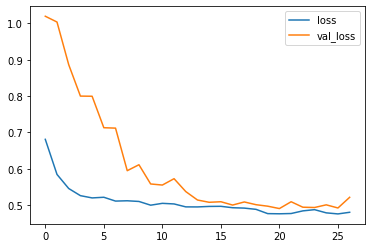

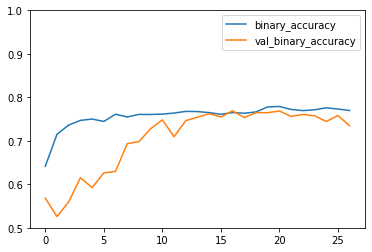

In [ ]:
_start = time.time()

ANNmodel , final_ann= Model(**optimal_config_format)
ret = analyseANN(ANNmodel, final_ann, X_train, y_train, X_test, y_test)

_end = time.time()

print(f'running for: {int((_end-_start)/60)}m, {int((_end-_start)%60)}s')
print(json.dumps(ret, indent=2))